In [14]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

import sys
module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)

# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

In [15]:
import glob
import joblib

In [16]:
from utils import convert_episodes_to_traj_class

In [17]:
from decision_bias_analysis_tools import ComputeFourBiasClips2
from parameters import EXPLORE, HOME_NODE, UnrewNamesSub
import evaluation_metrics as em

In [18]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.size"] = 18

In [158]:
# def load(model_name):
#     if model_name == 'Animals':
#         tfs = [LoadTrajFromPath(f'../outdata/{_}-tf') for _ in UnrewNamesSub]
#         return tfs

#     if model_name == 'BiasedWalk':
#         tfs = [LoadTrajFromPath(f'../outdata/{_}-RW5-tf') for _ in UnrewNamesSub]
#         return tfs
    
#     if model_name == 'RandomWalk':
#         tfs = [LoadTrajFromPath('../outdata/rw01-tf')]
#         return tfs
    
#     if model_name == 'MarkovChain':
#         tfs = [LoadTrajFromPath(f'../../Rosenberg-2021-Repository/outdata/{_}-MarkovSim-tf') for _ in UnrewNamesSub]
#         return tfs

#     tfs = []
#     for f in glob.glob(f'/Users/us3519/mouse-maze/figs/may28/{model_name}/MAX_LENGTH=500000/**/episodes_*.pkl'):
#         s = joblib.load(f)
#         tf = convert_episodes_to_traj_class(s["episodes_positions"], s["episodes_states"])
#         tfs.append(tf)
#     return tfs

def load(model_name):
    if model_name == 'Animals':
        tfs = [LoadTrajFromPath(f'../outdata/{_}-tf') for _ in UnrewNamesSub]
        return tfs

#     if model_name == 'BiasedWalk':
#         tfs = [LoadTrajFromPath(f'../outdata/{_}-RW5-tf') for _ in UnrewNamesSub]
#         return tfs
    
#     if model_name == 'RandomWalk':
#         tfs = [LoadTrajFromPath('../outdata/rw01-tf')]
#         return tfs
    
    if model_name == 'MarkovChain':
        tfs = [LoadTrajFromPath(f'../../Rosenberg-2021-Repository/outdata/{_}-MarkovSim-tf') for _ in UnrewNamesSub]
        return tfs

    tfs = []
    for f in glob.glob(f'/Users/us3519/mouse-maze/figs/may28/{model_name}/MAX_LENGTH=500000/**/episodes_*.pkl'):
        s = joblib.load(f)
        tf = convert_episodes_to_traj_class(s["episodes_positions"], s["episodes_states"])
        tfs.append(tf)
    return tfs

In [20]:
def ModeMask(tf,ma,re):
    '''
    Creates an array that parallels the bouts in tf giving the behavioral mode for every state
    0=home,1=drink,2=explore
    '''
    cl=SplitModeClips(tf,ma,re=True) # split the trajectory into mode clips
    ex=[np.zeros(len(b)) for b in tf.no] # list of arrays, one for each bout
    for c in cl: # for each clip
        ex[c[0]][c[1]:c[1]+c[2]]=c[3] # mark the states in the clip with the mode
    return ex


def CrossEntropy5(p,s):
    '''
    evaluate cross entropy for multinomial distribution p[m,n] and data s[n]
    p = array of predicted probability
    s = data as index into p[]
    '''
    return -np.sum([np.log(p[i,s[i]]) for i in range(len(s))])/len(s)/np.log(2) # cross entropy per sample


def FourBiasFit5(da,mk,ma):
    '''
    Computes 4 bias parameters from the node sequence da in maze ma
    da=sequence of node states
    mk=mask array, only consider actions into a state with mk==1
    Bf = prob of going forward when arriving from bottom of the T
    Ba = prob of making an alternating (instead of repeating) turn when going forward from bottom
    Lf = prob of going forward when arriving from L branch (or R branch)
    Lo = prob of turning out (instead of in) when going forward from L (or R)
    
    '''
    def Ratio(x,y): # check for divide by zero
        if y==0:
            return 0
        else:
            return x/y
        
    lo=1;hi=2**ma.le-2 # [lo,hi]=range of node numbers for T-junctions excluding node 0
    tr=np.zeros((4,4)) # transitions between steps: in left = 0; in right = 1; out left = 2; out right = 3
    st=np.array([-1]+[StepType(da[j-1],da[j],ma) for j in range(1,len(da))]) # step type that led to node i
    for i in range(1,len(st)-1): # correlate step i with step i+1
        if mk[i+1]==1:
            tr[st[i],st[i+1]]+=1
    Bf=Ratio(tr[0,0]+tr[0,1]+tr[1,0]+tr[1,1],np.sum(tr[0,:])+np.sum(tr[1,:])) # forward bias from bottom of T
    Ba=Ratio(tr[0,1]+tr[1,0],tr[0,0]+tr[0,1]+tr[1,0]+tr[1,1]) # alternating bias from bottom of T
    Lf=Ratio(tr[2,1]+tr[2,2]+tr[2,3]+tr[3,0]+tr[3,2]+tr[3,3],np.sum(tr[2,:])+np.sum(tr[3,:])) # forward bias from the side
    Lo=Ratio(tr[2,2]+tr[2,3]+tr[3,2]+tr[3,3],tr[2,1]+tr[2,2]+tr[2,3]+tr[3,0]+tr[3,2]+tr[3,3]) # out bias from the side                                      
    return [Bf,Ba,Lf,Lo]


def FourBiasPredict5(be,da,ma):
    '''
    be=list of 4 biases
    da=sequence of node states
    ma=maze
    Given the bias array be and the sequence of node states da, 
    computes the probability of each possible action at each place in the sequence
    '''
    def Ratio(x,y): # check for divide by zero
        if y==0:
            return 0
        else:
            return x/y
        
    Bf,Ba,Lf,Lo=be # the four biases
    pro=np.array( # probabilities for the next action, depending on the 4 kinds of last step
        [[Bf*(1-Ba),Bf*Ba,1-Bf], # 'in left' to ['in left','in right','out']
         [Bf*Ba,Bf*(1-Ba),1-Bf], # 'in right' to ['in left','in right','out']
         [1-Lf,Lf*(1-Lo),Lf*Lo], # 'out left' to ['in left','in right','out']
         [Lf*(1-Lo),1-Lf,Lf*Lo]]) # 'out right' to ['in left','in right','out']
    lo=1;hi=2**ma.le-2 # [lo,hi]=range of node numbers for T-junctions excluding node 0
    st=np.array([-1]+[StepType(da[j-1],da[j],ma) for j in range(1,len(da))]) # step type that led to state i
    # step types are: in left = 0; in right = 1; out left = 2; out right = 3
    pr=np.zeros((len(da),3)) # probabilities for the 3 kinds of action in left = 0; in right = 1; out = 2
    for i in range(1,len(st)-1): # predict action i+1 from step i
        if da[i]==0: # if we are at the first junction, node 0
            pr[i+1]=[0.5,0.5,0] # can only go left or right with equal prob
        elif da[i]<=hi: # if this is a T-junction other than node 0
            pr[i+1]=pro[st[i]] # set the probabilities according to the 4 biases bias
        else: # if this is an end node
            pr[i+1]=[0,0,1] # can only reverse
    return pr


def FourBiasWalkFit(tf,ma,tju=True,exp=True,rew=True,seg=5):
    '''
    Performs a Four-bias walk fit to predict actions in the trajectory tf on maze ma.
    tju = actions at T-junctions only?
    exp = actions in "explore" mode only?
    rew = animal rewarded (relevant only if exp==True)
    seg = number of segments for testing  
    returns average cross-entropy per action
    '''
    if exp:
        ex=ModeMask(tf,ma,rew) # one array for each bout marking states with mode = 0,1,2
    ce=0
    for i in range(seg): # for each testing segment
        dte=np.concatenate([b[:-2,0] for b in tf.no[i::seg]]) # test states, 1/seg
        mte=np.ones(len(dte));mte[0:2]=0 # test mask, can't predict first 2 actions
        ate=np.array([-1]+[StepType2(dte[j-1],dte[j],ma) for j in range(1,len(dte))]) # actions to be predicted
        dtr=np.concatenate([b[:-2,0] for j in range(seg) for b in tf.no[j::seg] if j!=i]) # train states, 1-1/seg
        mtr=np.ones(len(dtr));mtr[0:2]=0 # train mask, can't predict first 2 actions
        if tju: # restrict to actions taken from a T-junction
            mtr[np.where(np.logical_or(dtr[:-1]<1,dtr[:-1]>62))[0]+1]=0
            mte[np.where(np.logical_or(dte[:-1]<1,dte[:-1]>62))[0]+1]=0
        if exp: # restrict to actions taken to an explore state
            exe=np.concatenate([e[:-2] for e in ex[i::seg]]) # test mode
            exr=np.concatenate([e[:-2] for j in range(seg) for e in ex[j::seg] if j!=i]) # train mode
            mte[np.where(exe!=2)[0]]=0 # limit the test mask to explore mode
            mtr[np.where(exr!=2)[0]]=0 # limit the train mask to explore mode
        be=FourBiasFit5(dtr,mtr,ma) # measure bias parameters from the training set
        pte=FourBiasPredict5(be,dte,ma) # use these to get probabilities for the testing set
        ce+=CrossEntropy5(pte[mte==1],ate[mte==1]) # evaluate the cross entropy
    ce/=seg 
    return ce # average cross-entropy per action

In [157]:
ca=[]
ma = NewMaze()
for nickname in UnrewNamesSub:
    tf=LoadTrajFromPath(f'../outdata/{nickname}-tf')
    ce=FourBiasWalkFit(tf,ma,tju=True,exp=True,rew=False,seg=5)
    ca+=[ce]
    print(nickname, ce)
bi_ca = ca
bi_ce = sum(bi_ca)/len(UnrewNamesSub)
bi_ce

B5 1.458425266445894
B6 1.4908462353764478
B7 1.4858895518796178
D3 1.4366416244370845
D4 1.4301285666206016
D5 1.4798556776874352
D7 1.4585129697432397
D8 1.48376733890538
D9 1.5101486539372193


1.4704684316703245

In [33]:
def FixMarkovTrain3(da,mk,de,ma,tr=None):
    '''
    Fixed depth Markov chain, training
    No restriction on nodes except as specified by mk
    Collects counts for all combinations of history-action
    da = data
    mk = mask applied to action, Boolean
    de = depth of history
    ma = maze
    tr = translation array for node numbers to states
    '''
    if tr is not None:
        nt=np.max(tr)+1 # number of values for states
        st=tr[da] # translated state numbers
    else:
        nt=2**(ma.le+1)-1 # number of possible nodes, rightmost symbol in history is current node
        st=da # no translation
    sh=(3,)*(de-1)+(nt,)+(3,) # shape of counts array
    co=np.zeros(sh) # counts of history-action combinations
    ac=np.array([-1]+[StepType2(da[j-1],da[j],ma) for j in range(1,len(da))]) # forward actions
    hi=np.array([-1]+[StepType3(da[j-1],da[j],ma) for j in range(1,len(da))]) # history actions
    for i in range(de,len(da)): # i points to the action to be predicted
        if mk[i]:
            x=tuple(hi[i-de+1:i]) # start array pointer with history of preceding de-1 reverse actions
            x+=(st[i-1],) # add the most recent state
            co[x][ac[i]]+=1 # increase count for that action-history combination
#     print(co)
#     print("========", co.shape)
    return co


def VarMarkovTrain3(da,mk,mc,ma,tr):
    '''
    Variable depth Markov chain, training
    Starts by collecting counts for a fixed depth of histories
    Then prunes those histories, such that every remaining branch has at least mc counts
    Does that by "fusing" twigs that are below the cutoff, i.e. making the counts equal on all those twigs 
    da = data
    mk = mask applied to action, Boolean
    mc = minimum count for each history
    ma = maze
    tr = translation array for node numbers to states
    returns: 
    co=counts for each history-action combination
    br=histogram of history length, from l=1 to de
    '''
    de=6 # maximum depth allowed
    co=FixMarkovTrain3(da,mk,de,ma,tr) # get counts for each history-action, use routine for fixed depth
    br=np.zeros(de)
    if de==1: # If depth==1 we're done already, no pruning of histories
        br[0]=len(co) # number of histories with length 1
    else: # If depth>1 start pruning of histories
        cou=[] # list of arrays holding cumulative counts of all lower levels
        cou+=[co] # history length de, the raw counts, this will get modified in the pruning process
        for k in range(1,de): # after this we have pro[k] = total counts for histories of length de-k, k=0,...,de-1    
            cou+=[np.sum(cou[k-1],axis=0)] # sum over the earliest history element from lower level, length de-k
        for k in range(de-1,0,-1): # now go down the tree starting at level de-1 to see which children survive
            lo=np.where(np.sum(cou[k-1],axis=-1)<mc) # children whose sum of counts over actions is too small
            lp=set([tuple(x)[1:] for x in np.array(lo).T]) # set of locations of their parents
            br[de-k-1]=len(lp) # br[l]=number of branches that got cut at length l+1
            for p in lp: # for each of those parents
                for x in [0,1,2]: # for each of its children
                    cou[k-1][(x,)+p]=cou[k][p] # set counts equal to those of the parent
        br[de-1]=np.prod(co.shape[:-1]) # number of tips of the tree
        for l in range(de-1,0,-1): 
            br[l]=br[l]-3*br[l-1] # number of branches of length l+1
    return co,br

In [34]:
def FixMarkovTest3(da,mk,pr,ma,tr=None):
    '''
    Fixed depth Markov chain, testing
    da = data
    mk = mask applied to action, Boolean
    pr = probability array
    ma = maze
    tr = translation array for node numbers to states
    '''
    if tr is not None:
        st=tr[da] # translated state numbers
    else:
        st=da # no translation
    sh=pr.shape # shape of probability array
    de=len(sh)-1 # depth of history
    ac=np.array([-1]+[StepType2(da[j-1],da[j],ma) for j in range(1,len(da))]) # forward actions
    hi=np.array([-1]+[StepType3(da[j-1],da[j],ma) for j in range(1,len(da))]) # history actions
    pt=[] # predicted probabilities for the observed action
    for i in range(de,len(da)): # i points to the action to be predicted
        if mk[i]:
            x=tuple(hi[i-de+1:i]) # start array pointer with history of preceding de-1 reverse actions
            x+=(st[i-1],) # add the most recent state
            pt+=[pr[x][ac[i]]] # add probability for the observed action to the list
    ce=-np.sum(np.log(pt))/len(pt)/np.log(2) # cross-entropy
    return ce

In [35]:
def MarkovFit3(tf,ma,var=True,tju=True,exp=True,rew=True,seg=5,train=False,transl=None):
    '''
    Performs a Markov chain fit to predict actions in the trajectory tf on maze ma.
    Fit is restricted to T-junctions not including 0
    var = variable history depth?
    tju = actions at T-junctions only?
    exp = actions in "explore" mode only?
    rew = animal rewarded (relevant only if exp==True)
    seg = number of segments for testing 
    train = evaluate on training set?
    transl = array to convert node numbers into a reduced set of state numbers
    '''
    if exp:
        ex=ModeMask(tf,ma,rew) # one array for each bout marking states with mode = 0,1,2
    if var:
        par=np.array([2,3,5,10,20,40,80,160,320,640]) # min counts for the variable history
    else:
        par=np.array([1,2,3,4,5,6])[:1] # fixed depths 
    hi=np.zeros(len(par)) # to store the avg history string length
    ce=np.zeros(len(par)) # to store the cross entropy
    for i in range(seg):
#         print("Seg", i)
        dte=np.concatenate([b[:-2,0] for b in tf.no[i::seg]]) # test states
        mte=np.array([False]+[True,]*(len(dte)-1)) # mask for testing, all actions OK except first
        dtr=np.concatenate([b[:-2,0] for j in range(seg) for b in tf.no[j::seg] if j!=i]) # train states
        mtr=np.array([False]+[True,]*(len(dtr)-1)) # mask for training, all actions OK except first
        if tju: # restrict to actions taken from a T-junction, incl node 0
            mtr[np.where(dtr[:-1]>62)[0]+1]=False # mask for training, eliminate end nodes
            mte[np.where(dte[:-1]>62)[0]+1]=False # mask for testing, eliminate end nodes
        if exp: # restrict to actions taken to an explore state
            exe=np.concatenate([e[:-2] for e in ex[i::seg]]) # test mode
            exr=np.concatenate([e[:-2] for j in range(seg) for e in ex[j::seg] if j!=i]) # train mode
            mte[np.where(exe!=2)[0]]=False # limit the test mask to explore mode
            mtr[np.where(exr!=2)[0]]=False # limit the train mask to explore mode
        for j,k in enumerate(par):
#             print("par", j, k)
            if var:
                co,le=VarMarkovTrain3(dtr,mtr,k,ma,transl)                
                hi[j]+=np.sum(le*np.arange(len(le)))/np.sum(le)+1 # mean history length
            else:
                co=FixMarkovTrain3(dtr,mtr,k,ma,transl)                
                hi[j]+=k # history length
            su=np.sum(co,axis=-1).reshape(co.shape[:-1]+(1,)) # sum of counts over actions for each history
            pr=(co+1)/(su+3) # smoothed estimator of probability (note at node 0 there are just 2 options)
            if train:
                ce[j]+=FixMarkovTest3(dtr,mtr,pr,ma,transl) # evaluate on same as training data
            else:
                ce[j]+=FixMarkovTest3(dte,mte,pr,ma,transl) # evaluate on testing data
    hi/=seg
    ce/=seg
    si=np.argsort(hi) # sort by history length
    return hi[si],ce[si]

In [36]:
def MarkovAgentFitAnimalTest3(agent_tfs,animal_tfs,ma,var=True,tju=True,exp=True,rew=False,seg=5,train=False,transl=None):
    '''
    
    
    
    Performs a Markov chain fit to predict actions in the trajectory tf on maze ma.
    Fit is restricted to T-junctions not including 0
    var = variable history depth?
    tju = actions at T-junctions only?
    exp = actions in "explore" mode only?
    rew = animal rewarded (relevant only if exp==True)
    seg = number of segments for testing 
    train = evaluate on training set?
    transl = array to convert node numbers into a reduced set of state numbers
    '''
    
    agent_tf = agent_tfs
    animal_tf = animal_tfs
    
    if exp:
        ex_agent=ModeMask(agent_tf,ma,rew) # one array for each bout marking states with mode = 0,1,2
        ex_animal=ModeMask(animal_tf,ma,rew) # one array for each bout marking states with mode = 0,1,2

    if var:
        par=np.array([2,3,5,10,20,40,80,160,320,640]) # min counts for the variable history
    else:
        par=np.array([1,2,3,4,5,6]) # fixed depths 

    hi=np.zeros(len(par)) # to store the avg history string length
    ce=np.zeros(len(par)) # to store the cross entropy
    
    dtr=np.concatenate([b[:-2,0] for b in agent_tf.no]) # train states
#     dtr=np.concatenate([b[:-2,0] for agent_tf in agent_tfs for b in agent_tf.no]) # train states
    mtr=np.array([False]+[True,]*(len(dtr)-1)) # mask for training, all actions OK except first

    for i in range(seg):
        
        # different subsets of test data are tested
        dte=np.concatenate([b[:-2,0] for b in animal_tf.no[i::seg]]) # test states
#         dte=np.concatenate([b[:-2,0] for animal_tf in animal_tfs for b in animal_tf.no[i::seg]]) # test states
        mte=np.array([False]+[True,]*(len(dte)-1)) # mask for testing, all actions OK except first

        if tju: # restrict to actions taken from a T-junction, incl node 0
            mtr[np.where(dtr[:-1]>62)[0]+1]=False # mask for training, eliminate end nodes
            mte[np.where(dte[:-1]>62)[0]+1]=False # mask for testing, eliminate end nodes
        if exp: # restrict to actions taken to an explore state
            
            exe=np.concatenate([e[:-2] for e in ex_animal[i::seg]]) # test mode
            exr=np.concatenate([e[:-2] for e in ex_agent]) # train mode
            
            mte[np.where(exe!=2)[0]]=False # limit the test mask to explore mode
            mtr[np.where(exr!=2)[0]]=False # limit the train mask to explore mode

        for j,k in enumerate(par):
            if var:
                co,le=VarMarkovTrain3(dtr,mtr,k,ma,transl)                
                hi[j]+=np.sum(le*np.arange(len(le)))/np.sum(le)+1 # mean history length
            else:
                co=FixMarkovTrain3(dtr,mtr,k,ma,transl)                
                hi[j]+=k # history length
            su=np.sum(co,axis=-1).reshape(co.shape[:-1]+(1,)) # sum of counts over actions for each history
            pr=(co+1)/(su+3) # smoothed estimator of probability (note at node 0 there are just 2 options)
            if train:
                ce[j]+=FixMarkovTest3(dtr,mtr,pr,ma,transl) # evaluate on same as training data
            else:
                ce[j]+=FixMarkovTest3(dte,mte,pr,ma,transl) # evaluate on testing data
    hi/=seg
    ce/=seg
    si=np.argsort(hi) # sort by history length
    return hi[si],ce[si]

In [37]:
# make an array to translate nodes to states in groups {0},{t-junctions},{end nodes}
def TranslTJs(ma):
    '''
    discriminate by type of node; treat entry junction as separate from other T-junctions.
    '''
    tra=np.zeros(2**(ma.le+1)-1,dtype=int) # number of node values
    tra[0]=0 # entry junction
    tra[1:2**(ma.le)-1]=1 # other t junctions
    tra[2**(ma.le)-1:]=2 # end nodes
    return tra

def TranslLevels(ma):
    '''
    discriminate by level in the maze
    '''
    tra=np.zeros(2**(ma.le+1)-1,dtype=int) # number of node values
    for k in range(ma.le+1): # nodes level k
        tra[2**k-1:2**(k+1)-1]=k
    return tra

def TranslLevelsLR(ma):
    '''
    discriminate by level and whether an L or an R node
    '''
    tra=np.zeros(2**(ma.le+1)-1,dtype=int) # number of node values
    tra[0]=0 # nodes level 0
    for k in range(1,ma.le+1): # nodes level 1,...
        for j in range(2**k-1,2**(k+1)-1):
            tra[j]=2*k-1+StepType(ma.pa[j],j,ma) # This distinguishes L from R nodes
    return tra

In [69]:
model_colors = {
    'Animals': 'r',
    'TeAltOptions': 'g',
    'BiasedWalk4': 'y',
#     'MarkovChain': 'm',
    'RandomWalk': 'b',
    'Optimal': 'k:',
    'Uncertainty': 'tab:pink',
}

In [38]:
ma=NewMaze(6)

In [153]:
tealtopt_tf = load('TeAltOptions')[0]
unc_tf = load('Uncertainty')[0]


ce_dict = {
    'TeAltOptions': [],
    'Uncertainty': [],
#     'BiasedWalk4': []
}

In [154]:
a

9

In [155]:
a=0
for animal_tf in load('Animals'):
    hif,cef=MarkovAgentFitAnimalTest3(tealtopt_tf,animal_tf,ma,var=False,tju=True,exp=True,rew=False,seg=5,train=False,
                                      transl=TranslLevelsLR(ma))
    ce_dict['TeAltOptions'].append(cef)
    hif,cef=MarkovAgentFitAnimalTest3(unc_tf,animal_tf,ma,var=False,tju=True,exp=True,rew=False,seg=5,train=False,
                                      transl=TranslLevelsLR(ma))
    ce_dict['Uncertainty'].append(cef)
    
    print(f'Animal {a} done.')
    a += 1

Animal 0 done.
Animal 1 done.
Animal 2 done.
Animal 3 done.
Animal 4 done.
Animal 5 done.
Animal 6 done.
Animal 7 done.
Animal 8 done.


In [156]:
figpath = '/Users/us3519/mouse-maze/figs/paper figs/figure_results'

In [212]:
from scipy.stats import sem

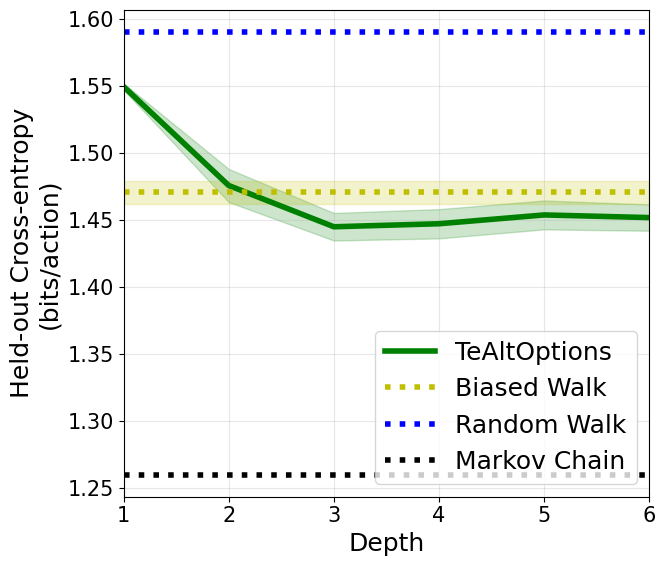

In [224]:
plt.figure(figsize=(7, 6))
ax = plt.gca()
de = np.arange(1, 7)

# for _ in range(len(ce_dict['TeAltOptions'])):
#     for m in ['TeAltOptions', 'Uncertainty'][:]:
#         ce_values = ce_dict[m][_]
#         plt.plot(de, ce_values, f'{model_colors[m]}', marker='o', markersize=5, alpha=0.4, label=m if _ == 1 else '')
#         plt.plot(de[np.argmin(ce_values)], np.min(ce_values), 'gray', marker='o', markersize=10, markerfacecolor='none')
#         plt.plot(de[np.argmin(ce_values)], np.min(ce_values), model_colors[m], marker='o', markersize=5)

m = 'TeAltOptions'
ce_values = np.array(ce_dict[m]).T
mean = np.mean(ce_values, axis=1)
ce_sem = sem(ce_values, axis=1)
plt.plot(de, np.mean(ce_values, axis=1), c=model_colors[m], linewidth=4, label=m)
plt.fill_between(de, mean + ce_sem, mean - ce_sem, color=model_colors[m], alpha=0.2)

plt.xlim(de[0]-0., de[-1]+0.)
plt.axhline(np.mean(bi_ca), ls=':', c=model_colors['BiasedWalk4'], lw=4, label='Biased Walk')
plt.fill_between(ax.get_xlim(), np.mean(bi_ca) + sem(bi_ca), np.mean(bi_ca) - sem(bi_ca), color=model_colors['BiasedWalk4'], alpha=0.2)

plt.axhline(1.59, ls=':', c=model_colors['RandomWalk'], lw=4, label='Random Walk')
plt.axhline(1.26, ls=':', c='k', lw=4, label='Markov Chain')

plt.ylabel('Held-out Cross-entropy\n(bits/action)', fontsize='medium')
plt.xlabel('Depth', fontsize='medium')
plt.yticks(fontsize='small')
plt.xticks(fontsize='small')
plt.grid(alpha=0.3)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f'{figpath}/ce_hmm.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()